# Generation and post-analysis in metabric dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import pandas as pd
import torch

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_1"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  B_WGTN  B_ECOGN  B_LDHN  B_HGB  BSEPON  MEDHINTN  \
0   97.0     1.0    1  39.0     0.0      0.0     0.0   31.0     0.0       0.0   
1  494.0     1.0    1  27.0     0.0      0.0     1.0    2.0     0.0       0.0   
2  234.0     1.0    1  41.0     1.0      0.0     0.0   29.0     0.0       0.0   
3  180.0     1.0    0  26.0     1.0      0.0     1.0   25.0     0.0       0.0   
4  647.0     0.0    0  13.0     1.0      0.0     0.0   83.0     0.0       0.0   

   PRTFN  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [4]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [10]:
# the datasets used for training is data_init_control
n_generated_dataset = 100

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict, n_generated_dataset, )
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=control_fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE
Epoch: [ 0]  time: 0.2411, ELBO_train: -15.65848970, KL_z: 2.27280986, KL_s: 0.06529379, reconstruction loss: -13.32038605
Epoch: [100]  time: 1.2485, ELBO_train: -11.51803303, KL_z: 0.37298809, KL_s: 0.01606083, reconstruction loss: -11.12898411
Epoch: [200]  time: 2.2375, ELBO_train: -10.69608021, KL_z: 0.33519934, KL_s: 0.01337004, reconstruction loss: -10.34751083
Epoch: [300]  time: 3.2389, ELBO_train: -10.53743887, KL_z: 0.34656903, KL_s: 0.01499772, reconstruction loss: -10.17587212
Epoch: [400]  time: 4.2539, ELBO_train: -10.66430759, KL_z: 0.37240899, KL_s: 0.01481926, reconstruction loss: -10.27707934
Epoch: [500]  time: 5.2840, ELBO_train: -10.56227779, KL_z: 0.42258464, KL_s: 0.01736581, reconstruction loss: -10.12232734
Epoch: [600]  time: 6.3065, ELBO_train: -10.42093086, KL_z: 0.43667366, KL_s: 0.01660109, reconstruction loss: -9.96765612
Epoch: [700]  time: 7.3366, ELBO_train: -10.46486759, KL_z: 0.46837081, KL_s: 0.01560092, reconstruction loss:

[2025-06-05T10:53:02.997495+0200][96048][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-05T10:53:04.802935+0200][96048][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  5%|▍         | 499/10000 [00:09<03:10, 49.91it/s]
[2025-06-05T10:53:20.774467+0200][96048][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-05T10:53:20.798483+0200][96048][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generate data by Surv-VAE


 95%|█████████▌| 950/1000 [00:25<00:01, 37.66it/s]


In [11]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [12]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

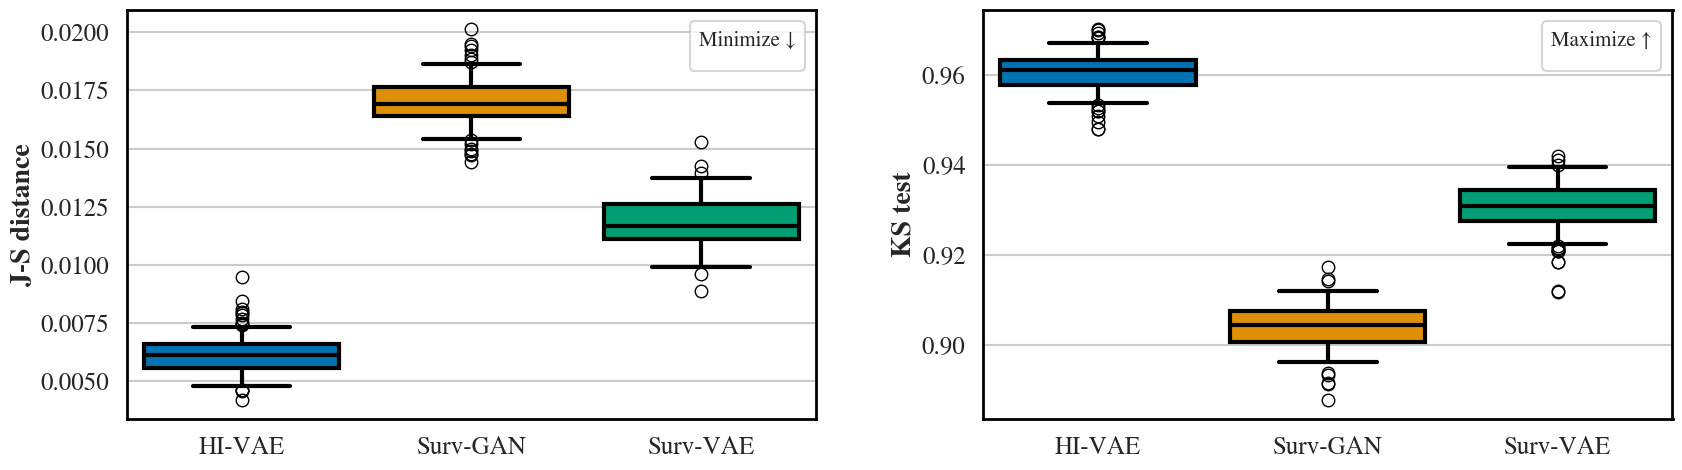

In [13]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

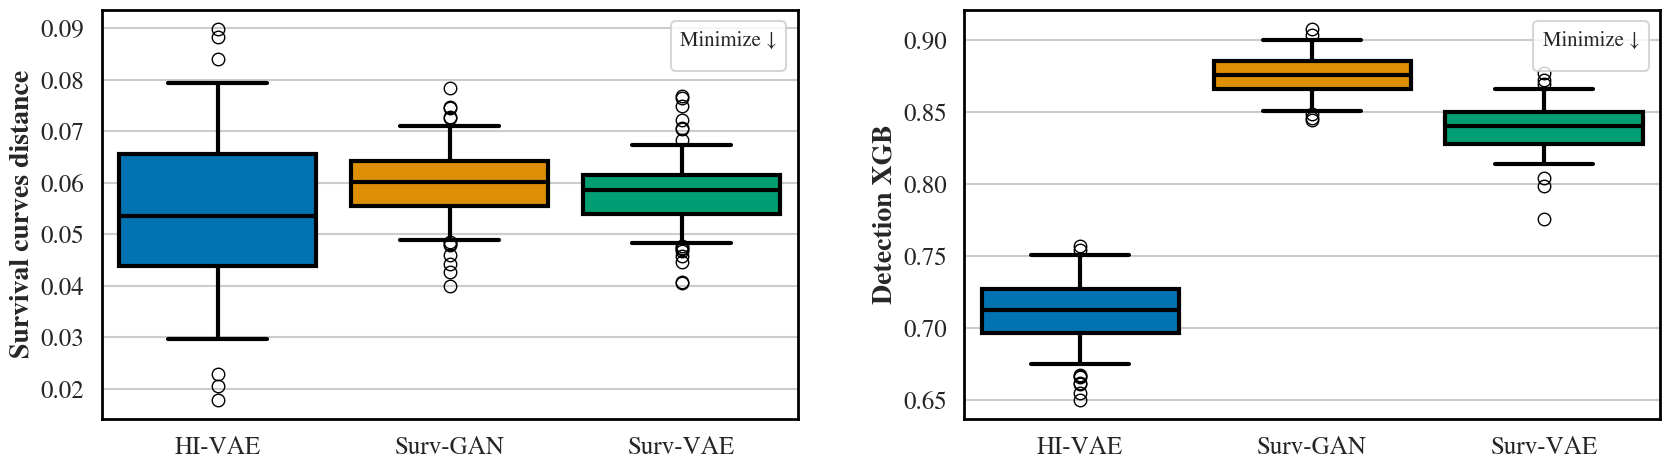

In [14]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

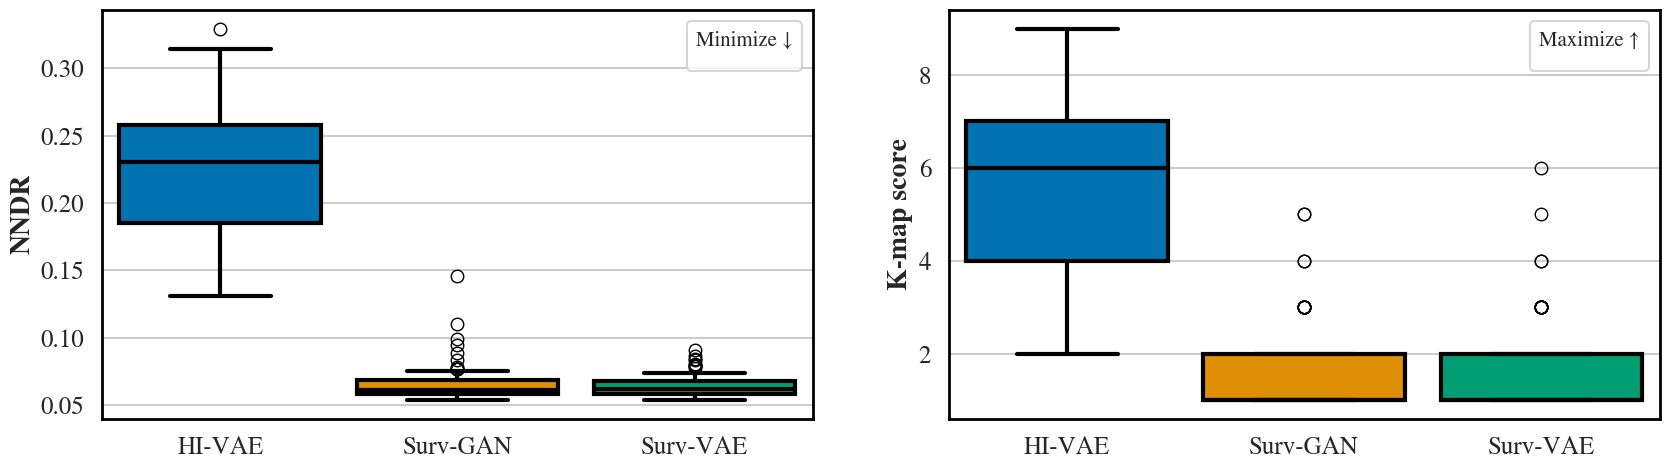

In [15]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [16]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

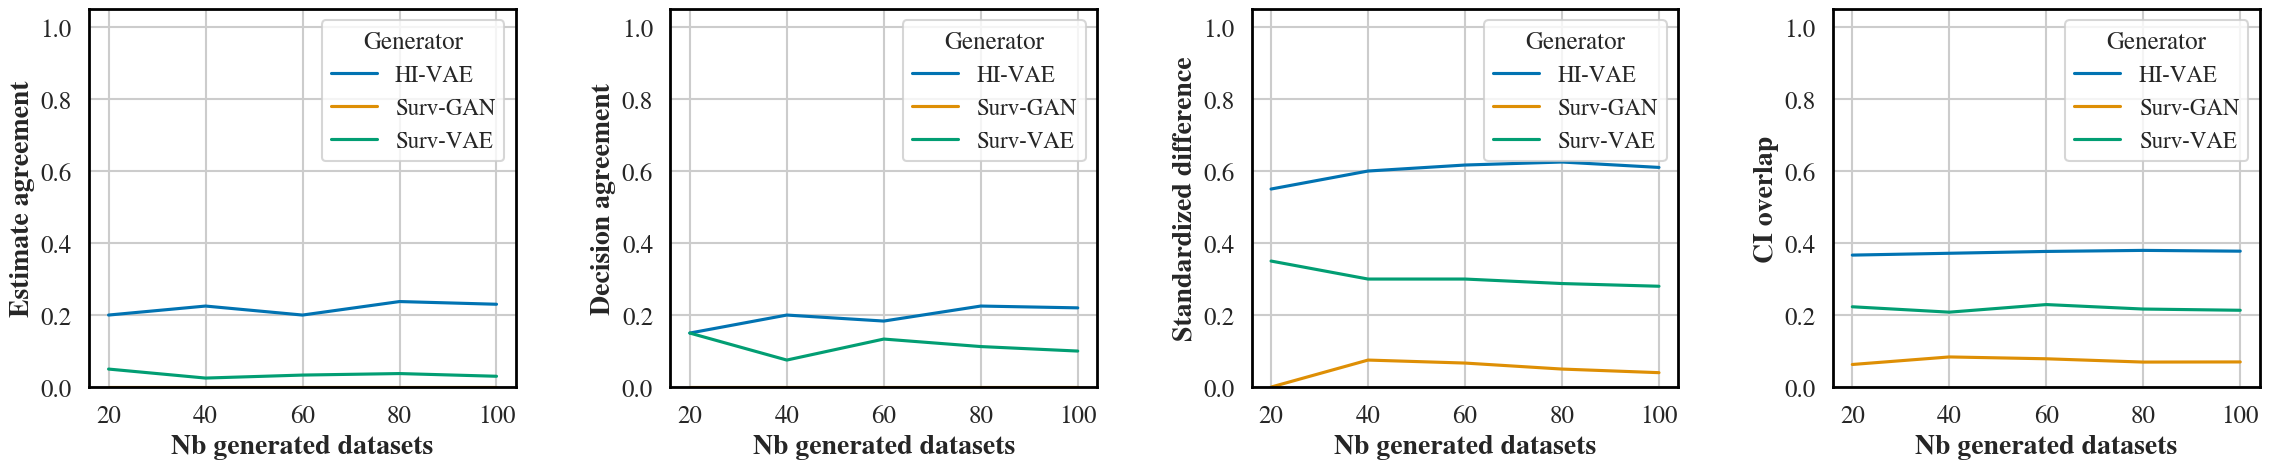

In [17]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [18]:
replicability_scores_df

,Generator,Nb generated datasets,Estimate agreement,Decision agreement,Standardized difference,CI overlap
0,HI-VAE,20,0.200000,0.150000,0.550000,0.366496
1,HI-VAE,40,0.225000,0.200000,0.600000,0.371595
2,HI-VAE,60,0.200000,0.183333,0.616667,0.376686
3,HI-VAE,80,0.237500,0.225000,0.625000,0.379607
4,HI-VAE,100,0.230000,0.220000,0.610000,0.377407
5,Surv-GAN,20,0.000000,0.000000,0.000000,0.062706
6,Surv-GAN,40,0.000000,0.000000,0.075000,0.083670
7,Surv-GAN,60,0.000000,0.000000,0.066667,0.078572
8,Surv-GAN,80,0.000000,0.000000,0.050000,0.069398
9,Surv-GAN,100,0.000000,0.000000,0.040000,0.069802


In [19]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

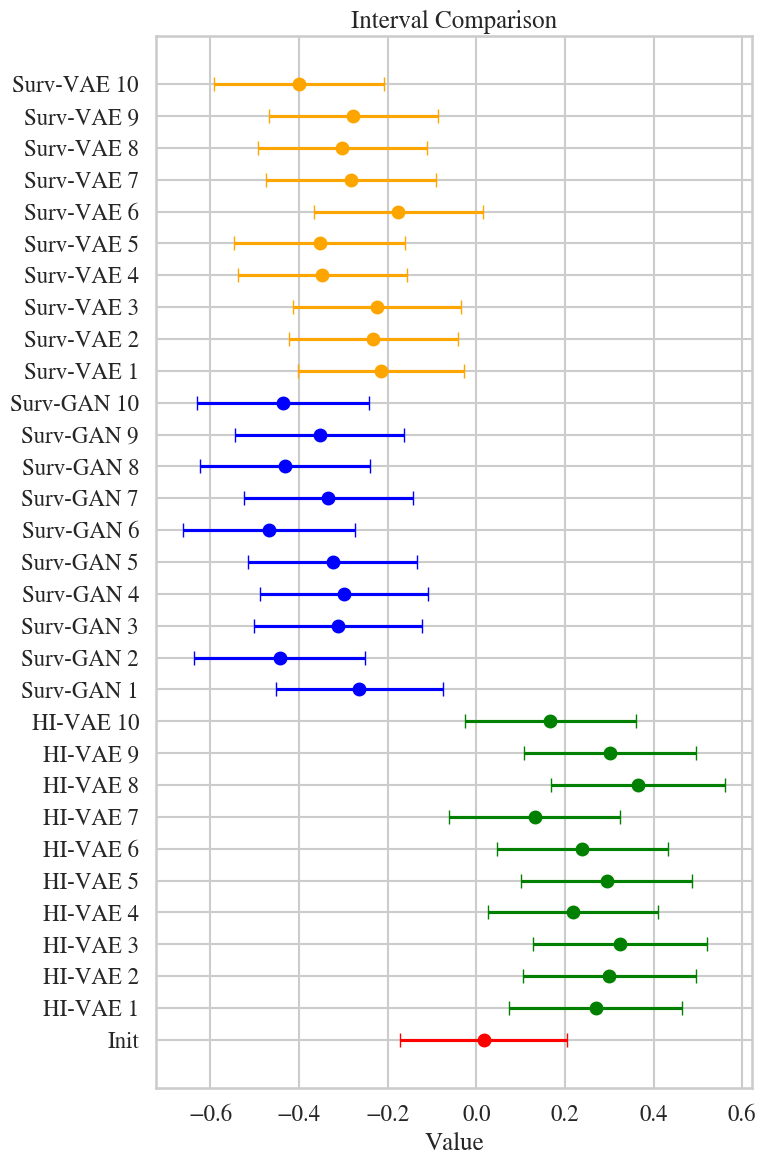

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()